# Desafio 2 - Predicción de Precios por m2 de Propiedades de Properati
# Grupo 5

**Integrantes:** Carolina Villa - Manuel Casella - Joaquin Vera - Guido Delfino - Martín Munoa - Fabricio Neyra

### Introducción
Como parte del Desafío 1 del curso trabajamos en la limpieza del dataset de propiedades de Properati. 
Parte de la estrategia inicial fue acotar el scope a departamentos ubicados en Capital Federal, para luego continuar con el Data Cleansing y el posterior análisis. 

En ésta oportunidad, retomamos el uso del dataset obtenido para encarar un nuevo **objetivo:**

**Predecir el precio por m2 de los departamentos ubicados en Capital Federal**

### Indice
[1- Importación de Librerías](#section_librerias)

[2- Importación del Dataset resultante del Desafio 1](#section_dataset)

...

<a id="section_librerias"></a> 
## 1- Importación de Librerías

In [16]:
#Librerías de Data Management

import numpy as np
import pandas as pd
import re

#Librerías de Machine Learning
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder



#Librerias de Visuaización
import seaborn as sns
import matplotlib.pyplot as plt
# %%matplotlib inline

<a id="section_dataset"></a>
# 2- Importación del Dataset resultante del Desafio 1

In [17]:
data=pd.read_csv("../Desafio_1/properati_desafio_final.csv")
print (data.info())
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24163 entries, 0 to 24162
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   property_type               24163 non-null  object 
 1   place_with_parent_names     24163 non-null  object 
 2   geonames_id                 23165 non-null  float64
 3   lat-lon                     18084 non-null  object 
 4   lat                         18084 non-null  float64
 5   lon                         18084 non-null  float64
 6   price                       22136 non-null  float64
 7   currency                    22136 non-null  object 
 8   price_aprox_local_currency  22136 non-null  float64
 9   price_aprox_usd             22136 non-null  float64
 10  surface_total_in_m2         19836 non-null  float64
 11  surface_covered_in_m2       22700 non-null  float64
 12  price_usd_per_m2            17998 non-null  float64
 13  price_per_m2                209

,property_type,place_with_parent_names,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,estacionamiento,esp_exterior,ameniti_sum,ameniti_seguridad,ameniti_laundry,ameniti_gimnasio,ameniti_parrilla,ameniti_piscina,ameniti_solarium,amenities
0,apartment,|Argentina|Capital Federal|Mataderos|,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,USD,1270404.0,72000.0,...,no,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,apartment,|Argentina|Capital Federal|Belgrano|,3436077.0,"-34.5598729,-58.443362",-34.559873,-58.443362,138000.0,USD,2434941.0,138000.0,...,no,NaN,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0
2,apartment,|Argentina|Capital Federal|Belgrano|,3436077.0,"-34.5598729,-58.443362",-34.559873,-58.443362,195000.0,USD,3440677.5,195000.0,...,no,NaN,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0


In [18]:
data_ap=data

## Correcciones de la base para tenes datos completos

### Buscamos los registros que son 'apto profesional'

In [19]:
#Buscamos los registros que hagan referencia a 4to piso

patron_amb="(apto|uso)(\s?profesional\s?)"
regex_amb=re.compile(patron_amb)

#Completamos la variable piso_clean con la data encontrada

match_1=data_ap['description_sin_tilde'].apply(lambda x: x if x is np.NaN else regex_amb.search(x))

data_ap.loc[match_1.notnull(),'apto_profesional']=1
match_1[match_1.notnull()]

1        <re.Match object; span=(127, 143), match='apto...
2        <re.Match object; span=(127, 143), match='apto...
3        <re.Match object; span=(158, 173), match='uso ...
4        <re.Match object; span=(133, 148), match='uso ...
22       <re.Match object; span=(692, 708), match='apto...
                               ...                        
24085    <re.Match object; span=(81, 98), match='apto p...
24088    <re.Match object; span=(406, 422), match='apto...
24089    <re.Match object; span=(128, 145), match='apto...
24090    <re.Match object; span=(57, 74), match='apto p...
24162    <re.Match object; span=(22, 38), match='apto p...
Name: description_sin_tilde, Length: 3586, dtype: object

In [20]:
data_ap['apto_profesional']=data_ap['apto_profesional'].fillna(0)
data_ap['apto_profesional'].sum()

3586.0

### Depuración columna Rooms

Vamos a buscar en la columna "description" todas aquellas líneas que diga "ambientes" para completar nulos en el campo "rooms". 

In [21]:


patron_amb="(?P<amb>\d)\s(ambiente)"
regex_amb=re.compile(patron_amb)

#Completamos la variable piso_clean con la data encontrada

match_1=data_ap['description_sin_tilde'].apply(lambda x: x if x is np.NaN else regex_amb.search(x))

data_ap.loc[match_1.notnull(),'rooms_clean']=match_1[match_1.notnull()].apply(lambda x: x.group("amb"))
pisos=data_ap[data_ap['rooms_clean'].notnull()][['rooms_clean']]
print(pisos.shape)


(11306, 1)


In [22]:


patron_amb="(dos)\s(ambientes)"
regex_amb=re.compile(patron_amb)

#Completamos la variable piso_clean con la data encontrada

match_1=data_ap['description_sin_tilde'].apply(lambda x: x if x is np.NaN else regex_amb.search(x))

data_ap.loc[match_1.notnull(),'rooms_clean']=2
pisos=data_ap[data_ap['rooms_clean'].notnull()][['rooms_clean']]
print(pisos.shape)



(12120, 1)


In [23]:

patron_amb="(tres)\s(ambientes)"
regex_amb=re.compile(patron_amb)

#Completamos la variable piso_clean con la data encontrada

match_1=data_ap['description_sin_tilde'].apply(lambda x: x if x is np.NaN else regex_amb.search(x))

data_ap.loc[match_1.notnull(),'rooms_clean']=3
pisos=data_ap[data_ap['rooms_clean'].notnull()][['rooms_clean']]
print(pisos.shape)



(12455, 1)


In [24]:

patron_amb="(un)\s(ambiente)"
regex_amb=re.compile(patron_amb)

#Completamos la variable piso_clean con la data encontrada

match_1=data_ap['description_sin_tilde'].apply(lambda x: x if x is np.NaN else regex_amb.search(x))

data_ap.loc[match_1.notnull(),'rooms_clean']=1
pisos=data_ap[data_ap['rooms_clean'].notnull()][['rooms_clean']]
print(pisos.shape)



(12780, 1)


In [25]:

patron_amb="(?P<amb>\d)\s?(amb)"
regex_amb=re.compile(patron_amb)

#Completamos la variable piso_clean con la data encontrada

match_1=data_ap['description_sin_tilde'].apply(lambda x: x if x is np.NaN else regex_amb.search(x))

data_ap.loc[match_1.notnull(),'rooms_clean']=match_1[match_1.notnull()].apply(lambda x: x.group("amb"))
pisos=data_ap[data_ap['rooms_clean'].notnull()][['rooms_clean']]
print(pisos.shape)



(14246, 1)


In [26]:

patron_amb="(mono)\s?(ambiente)"
regex_amb=re.compile(patron_amb)

#Completamos la variable piso_clean con la data encontrada

match_1=data_ap['description_sin_tilde'].apply(lambda x: x if x is np.NaN else regex_amb.search(x))

data_ap.loc[match_1.notnull(),'rooms_clean']=1
pisos=data_ap[data_ap['rooms_clean'].notnull()][['rooms_clean']]
print(pisos.shape)



(16578, 1)


In [27]:
data_ap[['rooms','rooms_clean']][(
    data_ap['rooms'].isnull())&(data_ap['rooms_clean'].isnull())]

,rooms,rooms_clean
96,NaN,NaN
120,NaN,NaN
176,NaN,NaN
183,NaN,NaN
184,NaN,NaN
...,...,...
24156,NaN,NaN
24157,NaN,NaN
24159,NaN,NaN
24160,NaN,NaN


In [28]:
# Unimos la informacion de floor. Si en floor hay datos lo mantenemos, sino completamos con la variable calculada de piso_clean

data_ap['amb_clean'] = data_ap.apply(lambda x: x['rooms'] if pd.notnull(x['rooms']) else x['rooms_clean'], axis=1)

# Chequeamos si en los casos donde había datos en floor se completó correctamente

data_ap.loc[data_ap['rooms'].notnull(),['rooms','rooms_clean','amb_clean']].head(15)

,rooms,rooms_clean,amb_clean
3,1.0,3,1
4,1.0,NaN,1
5,3.0,NaN,3
6,4.0,NaN,4
7,2.0,NaN,2
8,3.0,NaN,3
9,5.0,NaN,5
10,3.0,3,3
11,2.0,NaN,2
12,3.0,NaN,3


#### Vamos a depurar los precios por m2 de los barrios san cristobal y boedo

Como vimos que los precios por m2 de los barrios San Cristobal y Boedo no eran lógicos, lo topeamos en valores mas lógicos según el negocio. 
* Siendo para Boedo un precio promedio por metro cuadrado USD2388 y un precio por metro cuadrado máximo de USD5000.
* Siendo para San Cristobal un precio promedio por metro cuadrado USD2343 y un precio por metro cuadrado máximo de USD5000.

*Fuente:*

https://www.lanacion.com.ar/economia/dolar/barracas-devoto-colegiales-barrios-mas-se-encarecieron-nid2203920

In [30]:
# Agregar gráfico con el tope de 5000

In [31]:
data_ap['price_usd_per_m2_clean_2']=data_ap.apply(lambda x: 2388 if (x['Barrio']=='Boedo')&(x['price_usd_per_m2_clean']>5000)
                                                  else (2343 if (x['Barrio']=='San Cristobal')&(x['price_usd_per_m2_clean']>5000)
                                                   else  x['price_usd_per_m2_clean']), axis=1)

#### Vamos a completar los nulos con la media segun el barrio

In [32]:
data_ap['Barrio']=data_ap['Barrio'].fillna('')

In [33]:
def imputar_nulos(data,listado_barrios,variable_a_imputar):
    df=data.copy()
    for i in listado_barrios:
        mean=df[df['Barrio']==i][variable_a_imputar].mean()
        df[variable_a_imputar+'_3']=df.apply(
            lambda x: x[variable_a_imputar] if pd.notnull(x[variable_a_imputar]) else mean, axis=1)
    return df

In [34]:
list_barrios=data_ap['Barrio'].drop_duplicates().sort_values().to_list()
# list_barrios

* Imputamos los precios faltantes por m2 según la media del barrio

In [35]:
data_base=imputar_nulos(data_ap,list_barrios,'price_usd_per_m2_clean_2')
data_base.head()

,property_type,place_with_parent_names,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,ameniti_gimnasio,ameniti_parrilla,ameniti_piscina,ameniti_solarium,amenities,apto_profesional,rooms_clean,amb_clean,price_usd_per_m2_clean_2,price_usd_per_m2_clean_2_3
0,apartment,|Argentina|Capital Federal|Mataderos|,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,USD,1270404.00,72000.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2,2,1309.090909,1309.090909
1,apartment,|Argentina|Capital Federal|Belgrano|,3436077.0,"-34.5598729,-58.443362",-34.559873,-58.443362,138000.0,USD,2434941.00,138000.0,...,0.0,0.0,1.0,1.0,3.0,1.0,1,1,3066.666667,3066.666667
2,apartment,|Argentina|Capital Federal|Belgrano|,3436077.0,"-34.5598729,-58.443362",-34.559873,-58.443362,195000.0,USD,3440677.50,195000.0,...,0.0,0.0,1.0,1.0,3.0,1.0,2,2,3000.000000,3000.000000
3,apartment,|Argentina|Capital Federal|Palermo|Palermo Soho|,3430234.0,NaN,NaN,NaN,111700.0,USD,1970890.65,111700.0,...,1.0,0.0,1.0,1.0,3.0,1.0,3,1,2234.000000,2234.000000
4,apartment,|Argentina|Capital Federal|Palermo|Palermo Soho|,3430234.0,NaN,NaN,NaN,147900.0,USD,2609621.55,147900.0,...,1.0,0.0,1.0,1.0,3.0,1.0,NaN,1,3521.428571,3521.428571


In [36]:
# data_base[data_base['price_usd_per_m2_clean_2_3'].isnull()]['Barrio']
data_base['price_usd_per_m2_clean_2_3'].isnull().sum()

0

* Imputamos los m2 faltantes según la media del barrio

In [37]:
data_base=imputar_nulos(data_base,list_barrios,'m2_total_clean')
data_base.head()

,property_type,place_with_parent_names,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,ameniti_parrilla,ameniti_piscina,ameniti_solarium,amenities,apto_profesional,rooms_clean,amb_clean,price_usd_per_m2_clean_2,price_usd_per_m2_clean_2_3,m2_total_clean_3
0,apartment,|Argentina|Capital Federal|Mataderos|,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,USD,1270404.00,72000.0,...,0.0,0.0,0.0,1.0,0.0,2,2,1309.090909,1309.090909,55.0
1,apartment,|Argentina|Capital Federal|Belgrano|,3436077.0,"-34.5598729,-58.443362",-34.559873,-58.443362,138000.0,USD,2434941.00,138000.0,...,0.0,1.0,1.0,3.0,1.0,1,1,3066.666667,3066.666667,45.0
2,apartment,|Argentina|Capital Federal|Belgrano|,3436077.0,"-34.5598729,-58.443362",-34.559873,-58.443362,195000.0,USD,3440677.50,195000.0,...,0.0,1.0,1.0,3.0,1.0,2,2,3000.000000,3000.000000,65.0
3,apartment,|Argentina|Capital Federal|Palermo|Palermo Soho|,3430234.0,NaN,NaN,NaN,111700.0,USD,1970890.65,111700.0,...,0.0,1.0,1.0,3.0,1.0,3,1,2234.000000,2234.000000,50.0
4,apartment,|Argentina|Capital Federal|Palermo|Palermo Soho|,3430234.0,NaN,NaN,NaN,147900.0,USD,2609621.55,147900.0,...,0.0,1.0,1.0,3.0,1.0,NaN,1,3521.428571,3521.428571,42.0


In [38]:
data_base['m2_total_clean_3'].isnull().sum()

0

* Vamos a buscar una relacion entre los m2 y la cantidad de ambientes, para completar los registros con ambientes faltantes.

In [39]:
data_base['m2xamb']=(data_base['amb_clean'].astype(float)/data_base['m2_total_clean_3']).round(2)
lista=data_base['m2xamb']
avg_m2xamb=np.mean(lista[np.isfinite(lista)])
print('Obtuvimos una relacion de (m2 * ' + str(avg_m2xamb.round(4)),') = cantidad de ambientes')

Obtuvimos una relacion de (m2 * 0.0363 ) = cantidad de ambientes


Con esta información vamos a calcular la cantidad de ambientes faltantes

In [40]:
data_base['amb_clean_final']=data_base.apply(
    lambda x: x['amb_clean'] if pd.notnull(x['amb_clean']) else (x['m2_total_clean_3']*avg_m2xamb).round(0),axis=1)

In [41]:
data_base[data_base['amb_clean'].isnull()][['m2_total_clean_3','amb_clean','amb_clean_final']]

,m2_total_clean_3,amb_clean,amb_clean_final
96,122.000000,NaN,4
120,147.000000,NaN,5
176,67.571429,NaN,2
183,77.000000,NaN,3
184,101.000000,NaN,4
...,...,...,...
24156,91.000000,NaN,3
24157,38.000000,NaN,1
24159,157.000000,NaN,6
24160,113.000000,NaN,4


In [42]:
data_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24163 entries, 0 to 24162
Data columns (total 54 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   property_type               24163 non-null  object 
 1   place_with_parent_names     24163 non-null  object 
 2   geonames_id                 23165 non-null  float64
 3   lat-lon                     18084 non-null  object 
 4   lat                         18084 non-null  float64
 5   lon                         18084 non-null  float64
 6   price                       22136 non-null  float64
 7   currency                    22136 non-null  object 
 8   price_aprox_local_currency  22136 non-null  float64
 9   price_aprox_usd             22136 non-null  float64
 10  surface_total_in_m2         19836 non-null  float64
 11  surface_covered_in_m2       22700 non-null  float64
 12  price_usd_per_m2            17998 non-null  float64
 13  price_per_m2                209

In [43]:
data_base['esp_exterior'].value_counts()

balcon     11850
patio       2089
terraza     1330
Name: esp_exterior, dtype: int64

In [44]:
def media_barrios(data,listado_barrios,variable_a_imputar):
    df=data.copy()
    barrios_medias=pd.DataFrame()
    for i in range(len(listado_barrios)):
        mean=df[df['Barrio']==listado_barrios[i]][variable_a_imputar].mean()
#         barrios_medias=barrios_medias.append(str(i))
        barrios_medias.loc[i,'Barrios']=listado_barrios[i]
        barrios_medias.loc[i,'media']=mean
    return barrios_medias

In [45]:
medias=media_barrios(data_base,list_barrios,'price_usd_per_m2_clean_2_3')

In [46]:
medias.sort_values(by='media', ascending=False)

,Barrios,media
35,Puerto Madero,4934.016628
20,Las Cañitas,3343.031454
27,Palermo,3122.024243
36,Recoleta,3089.097140
25,Nuñez,3002.315018
7,Belgrano,2961.166513
6,Barrio Norte,2876.624229
37,Retiro,2820.099329
15,Colegiales,2546.249079
14,Coghlan,2514.575986


Tenemos tres variables categoricas:
   * estacionamiento
   * esp_exterior
   * Barrio
   

In [48]:
data_base['estacionamiento'].value_counts()

no    19164
si     4999
Name: estacionamiento, dtype: int64

In [49]:
data_base['esp_exterior'].value_counts()

balcon     11850
patio       2089
terraza     1330
Name: esp_exterior, dtype: int64

In [56]:
data_base['amb_clean_final']=data_base['amb_clean_final'].astype(int)

* Vamos a topear los precios para no tener tanta amplitud de los precios, lo vamos a topear a la mediana +/- 1 desvío

In [339]:
def mediana_barrios(data,listado_barrios,variable_a_imputar):
    df=data.copy()
    barrios_medianas=pd.DataFrame()
    for i in range(len(listado_barrios)):
        mediana=df[df['Barrio']==listado_barrios[i]][variable_a_imputar].median()
        desvio=df[df['Barrio']==listado_barrios[i]][variable_a_imputar].std()
        barrios_medianas.loc[i,'Barrio']=listado_barrios[i]
        barrios_medianas.loc[i,'mediana+desvio']=mediana+desvio
        barrios_medianas.loc[i,'mediana-desvio']=mediana-desvio
    return barrios_medianas

In [472]:
list_barrios=data_base['Barrio'].drop_duplicates().sort_values().to_list()

In [473]:
medianas=mediana_barrios(data_base,list_barrios,'price_usd_per_m2_clean_2_3')
# medianas
data_base2=pd.merge(data_base, medianas, on="Barrio")
data_base2.head()

,property_type,place_with_parent_names,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,m2xamb,amb_clean_final,categoria_barrio,esp_exterior_dummy,estacionamiento_dummy,barrio_alto,barrio_medio_bajo,barrio_bajo,mediana+desvio,mediana-desvio
0,apartment,|Argentina|Capital Federal|Mataderos|,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,USD,1270404.0,72000.0,...,0.04,2,bajo,0,0,0,0,1,2772.485261,1443.889008
1,apartment,|Argentina|Capital Federal|Mataderos|,3430787.0,"-34.6632395,-58.5056703",-34.663240,-58.505670,67000.0,USD,1182181.5,67000.0,...,NaN,1,bajo,1,0,0,0,1,2772.485261,1443.889008
2,apartment,|Argentina|Capital Federal|Mataderos|,3430787.0,"-34.6453868897,-58.4944637661",-34.645387,-58.494464,NaN,NaN,NaN,NaN,...,0.02,1,medio,1,0,0,0,0,2772.485261,1443.889008
3,apartment,|Argentina|Capital Federal|Mataderos|,3430787.0,"-34.6511836146,-58.514746928",-34.651184,-58.514747,90000.0,USD,1588005.0,90000.0,...,0.04,2,bajo,0,0,0,0,1,2772.485261,1443.889008
4,apartment,|Argentina|Capital Federal|Mataderos|,3430787.0,"-34.6469252,-58.4926716",-34.646925,-58.492672,NaN,NaN,NaN,NaN,...,0.03,2,medio,0,0,0,0,0,2772.485261,1443.889008


In [474]:
data_base2['price']=data_base2.apply(lambda x: 
                                     x['mediana+desvio'] if x['price_usd_per_m2_clean_2_3']>x['mediana+desvio'] else
                                    (x['mediana-desvio'] if x['price_usd_per_m2_clean_2_3']<x['mediana-desvio'] else
                                    x['price_usd_per_m2_clean_2_3']),axis=1)

In [475]:
data=data_base2[['price', 'amb_clean_final', 'm2_total_clean_3', 'amenities', 
               'expenses_ok', 'estacionamiento','apto_profesional',
                'esp_exterior',  'Barrio']]

In [476]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24163 entries, 0 to 24162
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             24163 non-null  float64
 1   amb_clean_final   24163 non-null  int32  
 2   m2_total_clean_3  24163 non-null  float64
 3   amenities         24163 non-null  float64
 4   expenses_ok       5694 non-null   float64
 5   estacionamiento   24163 non-null  object 
 6   apto_profesional  24163 non-null  float64
 7   esp_exterior      15269 non-null  object 
 8   Barrio            24163 non-null  object 
dtypes: float64(5), int32(1), object(3)
memory usage: 1.8+ MB


* Para poder generar las variables dummies vamos a corregir los NA

In [477]:
data['expenses_ok'].fillna(0,inplace=True)

C:\Users\Administrator\anaconda3\envs\dhdsblend\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [478]:
data['esp_exterior'].fillna("",inplace=True)

In [479]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24163 entries, 0 to 24162
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             24163 non-null  float64
 1   amb_clean_final   24163 non-null  int32  
 2   m2_total_clean_3  24163 non-null  float64
 3   amenities         24163 non-null  float64
 4   expenses_ok       24163 non-null  float64
 5   estacionamiento   24163 non-null  object 
 6   apto_profesional  24163 non-null  float64
 7   esp_exterior      24163 non-null  object 
 8   Barrio            24163 non-null  object 
dtypes: float64(5), int32(1), object(3)
memory usage: 1.8+ MB


# Vamos a analizar la correlación entre las variables

In [480]:
# Importing matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<AxesSubplot:>

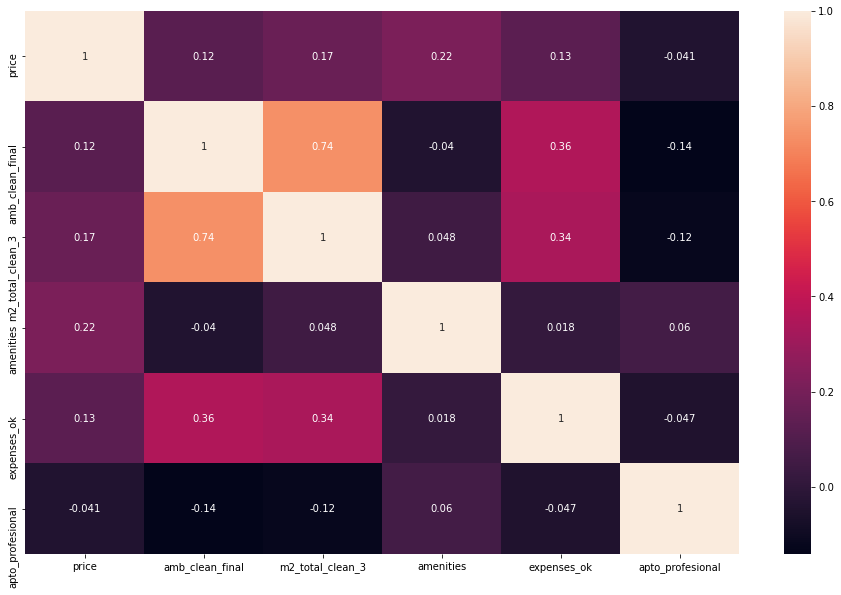

In [548]:
# Visualizamos la matriz de correlación entre variables
plt.figure(figsize = (16,10))     # Size of the figure
sns.heatmap(data.corr(),annot = True)

Notamos la presencia de las correlaciones más fuertes se dan en 'barrio_alto' con la variable "price", m2_total_clean_3 y  amb_clean_final,  y en y 'expenses_ok' con "amb_clean_final"

### Data Preparation

* Como nuestro objetivo es precedir el precio por metro cuadrado para los departamentos ubicados en la Capital Federal, nuestra variable target (y) será "price". Utilizaremos un cojunto de parametros (X) que se presume que poseen relación con dicha variable, para poder estimar con mayor precisión su valor.

In [482]:
y = data["price"]
X = data[[x for x in data.columns if x != "price"]]


In [483]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [484]:
y_train.reset_index(drop=True,inplace=True)
X_train.reset_index(drop=True,inplace=True)

In [485]:
y_test.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

In [486]:
cat_cols = [x for x in X.select_dtypes(include=['object']).columns]
cat_cols

['estacionamiento', 'esp_exterior', 'Barrio']

In [487]:
num_cols = [x for x in X.columns if x not in cat_cols]
num_cols

['amb_clean_final',
 'm2_total_clean_3',
 'amenities',
 'expenses_ok',
 'apto_profesional']

In [488]:
onehot_encoder = OneHotEncoder(sparse=False,drop='first',handle_unknown='error')
X_one_hot_train = onehot_encoder.fit_transform(X_train[cat_cols])
X_one_hot_train = pd.DataFrame(X_one_hot_train, columns = onehot_encoder.get_feature_names())
X_one_hot_train.head()

,x0_si,x1_balcon,x1_patio,x1_terraza,x2_Abasto,x2_Agronomía,x2_Almagro,x2_Balvanera,x2_Barracas,x2_Barrio Norte,...,x2_Villa Lugano,x2_Villa Luro,x2_Villa Ortuzar,x2_Villa Pueyrredón,x2_Villa Real,x2_Villa Riachuelo,x2_Villa Santa Rita,x2_Villa Soldati,x2_Villa Urquiza,x2_Villa del Parque
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [489]:
X_proc_train = pd.concat([X_train[num_cols],X_one_hot_train],axis=1)
X_proc_train[['amb_clean_final','amenities','expenses_ok','apto_profesional'
             ]] = X_proc_train[['amb_clean_final','amenities','expenses_ok','apto_profesional']].fillna(0)

In [490]:
#Analizamos la forma de los conjuntos de datos de prueba y test
print("X_proc_train shape", X_proc_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_proc_train shape (16914, 66)
y_train shape (16914,)
X_test shape (7249, 8)
y_test shape (7249,)


### Construcción del Modelo con Statsmodels

Vamos a construir nuestro modelo de Machine Learning utilizando una Regresión Lineal Multiple. Comenzaremos aplicando la librería de "Statsmodels" para entrenar y evaluar posteriormente la precisión de las predicciones.

In [491]:
from sklearn.preprocessing import StandardScaler
scaled_features = X_proc_train.copy()
col_names = X_proc_train.columns.to_list()
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[col_names] = features
# print(scaled_features)

Agregamos el intercepto

In [492]:
X_proc_esc_train = sm.add_constant(scaled_features)

### Entrenamos el modelo

In [493]:
lm = sm.OLS(y_train,X_proc_esc_train).fit()

Analizamos los principales parámetros para medir la efectividad del modelo

In [494]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     349.3
Date:                Thu, 14 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:02:24   Log-Likelihood:            -1.2840e+05
No. Observations:               16914   AIC:                         2.569e+05
Df Residuals:                   16847   BIC:                         2.575e+05
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

Realizamos la codificación a variables dummies de la variable Barrio, pero como tenemos un 40% de las variables de barrio con un p value mayor a 0.05 vamos a generar categorías por barrios.
Para esto vamos a calcula el precio medio por metro cuadrado por barrio para definir las categorías.

In [495]:
def media_barrios(data,listado_barrios,variable_a_imputar):
    df=data.copy()
    barrios_medias=pd.DataFrame()
    for i in range(len(listado_barrios)):
        mean=df[df['Barrio']==listado_barrios[i]][variable_a_imputar].mean()
#         barrios_medias=barrios_medias.append(str(i))
        barrios_medias.loc[i,'Barrios']=listado_barrios[i]
        barrios_medias.loc[i,'media']=mean
    return barrios_medias

In [496]:
medias=media_barrios(data,list_barrios,'price')
medias.sort_values(by='media', ascending=False)

,Barrios,media
35,Puerto Madero,5266.742599
20,Las Cañitas,3248.343882
36,Recoleta,2946.015877
27,Palermo,2945.104275
7,Belgrano,2831.447172
25,Nuñez,2798.541365
6,Barrio Norte,2723.274206
37,Retiro,2637.189000
14,Coghlan,2482.443458
15,Colegiales,2466.456393


In [497]:
data['categoria_barrio']=data.apply(
    lambda x: 'alto' if x['price']>2500 else
              ('medio' if x['price']>2200  else
              ('medio_bajo' if x['price']>2050 else 'bajo')),axis=1)

C:\Users\Administrator\anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [498]:
data['categoria_barrio'].value_counts()

alto          9416
medio         8798
bajo          4415
medio_bajo    1534
Name: categoria_barrio, dtype: int64

In [499]:
data=data[['price', 'amb_clean_final', 'm2_total_clean_3', 'amenities',
       'expenses_ok', 'estacionamiento', 'apto_profesional', 'esp_exterior',
       'categoria_barrio']]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24163 entries, 0 to 24162
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             24163 non-null  float64
 1   amb_clean_final   24163 non-null  int32  
 2   m2_total_clean_3  24163 non-null  float64
 3   amenities         24163 non-null  float64
 4   expenses_ok       24163 non-null  float64
 5   estacionamiento   24163 non-null  object 
 6   apto_profesional  24163 non-null  float64
 7   esp_exterior      24163 non-null  object 
 8   categoria_barrio  24163 non-null  object 
dtypes: float64(5), int32(1), object(3)
memory usage: 1.8+ MB


In [500]:
y = data["price"]
X = data[[x for x in data.columns if x != "price"]]


In [501]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)
y_train.reset_index(drop=True,inplace=True)
X_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
cat_cols = [x for x in X.select_dtypes(include=['object']).columns]
num_cols = [x for x in X.columns if x not in cat_cols]
onehot_encoder = OneHotEncoder(sparse=False,drop='first',handle_unknown='error')
X_one_hot_train = onehot_encoder.fit_transform(X_train[cat_cols])
X_one_hot_train = pd.DataFrame(X_one_hot_train, columns = onehot_encoder.get_feature_names())
X_one_hot_train.head()
X_proc_train = pd.concat([X_train[num_cols],X_one_hot_train],axis=1)
X_proc_train[['amb_clean_final','amenities','expenses_ok','apto_profesional'
             ]] = X_proc_train[['amb_clean_final','amenities','expenses_ok','apto_profesional']].fillna(0)

### Cargamos fórmulas para metricas y errores

In [502]:
#Definimos la funicón para calcular Variance Inflation Factor
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

In [503]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

### Aplicamos modelo de Stats

In [504]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)
y_train.reset_index(drop=True,inplace=True)
X_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
cat_cols = [x for x in X.select_dtypes(include=['object']).columns]
num_cols = [x for x in X.columns if x not in cat_cols]
onehot_encoder = OneHotEncoder(sparse=False,drop='first',handle_unknown='error')
X_one_hot_train = onehot_encoder.fit_transform(X_train[cat_cols])
X_one_hot_train = pd.DataFrame(X_one_hot_train, columns = onehot_encoder.get_feature_names())
X_one_hot_train.head()
X_proc_train = pd.concat([X_train[num_cols],X_one_hot_train],axis=1)
X_proc_train[['amb_clean_final','amenities','expenses_ok','apto_profesional'
             ]] = X_proc_train[['amb_clean_final','amenities','expenses_ok','apto_profesional']].fillna(0)

In [505]:
onehot_encoder = OneHotEncoder(sparse=False,drop='first',handle_unknown='error')
X_one_hot_test = onehot_encoder.fit_transform(X_test[cat_cols])
X_one_hot_test = pd.DataFrame(X_one_hot_test, columns = onehot_encoder.get_feature_names())
X_one_hot_test.head()
X_proc_test = pd.concat([X_test[num_cols],X_one_hot_test],axis=1)
X_proc_test[['amb_clean_final','amenities','expenses_ok','apto_profesional'
             ]] = X_proc_test[['amb_clean_final','amenities','expenses_ok','apto_profesional']].fillna(0)

* Normalizamos el data set de train

In [506]:
from sklearn.preprocessing import StandardScaler
scaled_features = X_proc_train.copy()
col_names = X_proc_train.columns.to_list()
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[col_names] = features
# print(scaled_features)

* Normalizamos el data set de test

In [507]:
from sklearn.preprocessing import StandardScaler
scaled_features_test = X_proc_test.copy()
col_names = X_proc_test.columns.to_list()
features_test = scaled_features_test[col_names]
scaler = StandardScaler().fit(features_test.values)
features_test = scaler.transform(features_test.values)
scaled_features_test[col_names] = features_test
# print(scaled_features)

In [508]:
#Construimos el modelo con Statsmodel
X_proc_esc_train = sm.add_constant(scaled_features)
X_proc_esc_test = sm.add_constant(scaled_features_test)
print(X_proc_esc_train.shape)
print(X_proc_esc_test.shape)
#entrenamos el modelo
lm = sm.OLS(y_train,X_proc_esc_train).fit()

(16914, 13)
(7249, 13)


In [509]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     2302.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:02:26   Log-Likelihood:            -1.2751e+05
No. Observations:               16914   AIC:                         2.550e+05
Df Residuals:                   16901   BIC:                         2.551e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2566.3396      3.497  

In [510]:
y_pred = lm.predict(X_proc_esc_test)
regression_results(y_test, y_pred)

explained_variance:  0.6291
mean_squared_log_error:  0.017
r2:  0.6277
MAE:  255.6569
MSE:  190116.8939
RMSE:  436.024


In [511]:
vif_cal(X_proc_esc_train,"const")

,Var,Vif
0,amb_clean_final,2.37
1,m2_total_clean_3,2.35
10,x2_medio,1.30
9,x2_bajo,1.29
6,x1_balcon,1.24
3,expenses_ok,1.19
7,x1_patio,1.16
2,amenities,1.11
5,x0_si,1.11
8,x1_terraza,1.11


* Como vemos que la variable `x1_terraza` tiene un p value mayor a 0.05 vamos a eliminar esta variable y volver a entrenar el modelo

In [512]:
X_proc_esc_train.drop(['x1_terraza'], axis=1,inplace=True)
X_proc_esc_test.drop(['x1_terraza'], axis=1,inplace=True)

In [513]:
lm = sm.OLS(y_train,X_proc_esc_train).fit()

In [514]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     2511.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:02:26   Log-Likelihood:            -1.2751e+05
No. Observations:               16914   AIC:                         2.550e+05
Df Residuals:                   16902   BIC:                         2.551e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2566.3396      3.497  

In [515]:
y_pred = lm.predict(X_proc_esc_test)
regression_results(y_test, y_pred)

explained_variance:  0.6291
mean_squared_log_error:  0.017
r2:  0.6276
MAE:  255.6606
MSE:  190135.463
RMSE:  436.0453


In [516]:
vif_cal(X_proc_esc_train,"const")

,Var,Vif
0,amb_clean_final,2.37
1,m2_total_clean_3,2.34
9,x2_medio,1.30
8,x2_bajo,1.29
3,expenses_ok,1.19
6,x1_balcon,1.14
7,x1_patio,1.13
10,x2_medio_bajo,1.11
5,x0_si,1.10
2,amenities,1.09


* Como vemos que la variable `expenses_ok` tiene un p value mayor a 0.05 vamos a eliminar esta variable y volver a entrenar el modelo

In [517]:
X_proc_esc_train.drop(['expenses_ok'], axis=1,inplace=True)
X_proc_esc_test.drop(['expenses_ok'], axis=1,inplace=True)

In [518]:
lm = sm.OLS(y_train,X_proc_esc_train).fit()

In [519]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     2762.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:02:27   Log-Likelihood:            -1.2751e+05
No. Observations:               16914   AIC:                         2.550e+05
Df Residuals:                   16903   BIC:                         2.551e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2566.3396      3.497  

In [520]:
y_pred = lm.predict(X_proc_esc_test)
regression_results(y_test, y_pred)

explained_variance:  0.6292
mean_squared_log_error:  0.017
r2:  0.6277
MAE:  255.6675
MSE:  190095.9738
RMSE:  436.0


In [521]:
vif_cal(X_proc_esc_train,"const")

,Var,Vif
1,m2_total_clean_3,2.32
0,amb_clean_final,2.30
7,x2_bajo,1.28
8,x2_medio,1.28
5,x1_balcon,1.14
6,x1_patio,1.13
9,x2_medio_bajo,1.11
4,x0_si,1.10
2,amenities,1.09
3,apto_profesional,1.03


* En el summary vemos que la variable `amb_clean_final` tiene relación negativa con el precio, lo cual no creemos lógico, por esto vamos a eliminar esta variable y volver a entrenar nuestro modelo

In [522]:
X_proc_esc_train.drop(['amb_clean_final'], axis=1,inplace=True)
X_proc_esc_test.drop(['amb_clean_final'], axis=1,inplace=True)

In [523]:
lm = sm.OLS(y_train,X_proc_esc_train).fit()

In [524]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     3062.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:02:27   Log-Likelihood:            -1.2752e+05
No. Observations:               16914   AIC:                         2.551e+05
Df Residuals:                   16904   BIC:                         2.551e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2566.3396      3.500  

In [525]:
y_pred = lm.predict(X_proc_esc_test)
regression_results(y_test, y_pred)

explained_variance:  0.6287
mean_squared_log_error:  0.017
r2:  0.6273
MAE:  255.5448
MSE:  190321.8511
RMSE:  436.2589


In [526]:
vif_cal(X_proc_esc_train,"const")

,Var,Vif
6,x2_bajo,1.28
7,x2_medio,1.28
4,x1_balcon,1.14
5,x1_patio,1.13
8,x2_medio_bajo,1.11
3,x0_si,1.10
0,m2_total_clean_3,1.08
1,amenities,1.08
2,apto_profesional,1.02


* En el summary vemos que la variable `apto_profesional` tiene relación negativa con el precio, lo cual no creemos lógico, por esto vamos a eliminar esta variable y volver a entrenar nuestro modelo

In [527]:
X_proc_esc_train.drop(['apto_profesional'], axis=1,inplace=True)
X_proc_esc_test.drop(['apto_profesional'], axis=1,inplace=True)

In [528]:
lm = sm.OLS(y_train,X_proc_esc_train).fit()

In [529]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     3443.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:02:28   Log-Likelihood:            -1.2752e+05
No. Observations:               16914   AIC:                         2.551e+05
Df Residuals:                   16905   BIC:                         2.551e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2566.3396      3.500  

In [530]:
y_pred = lm.predict(X_proc_esc_test)
regression_results(y_test, y_pred)

explained_variance:  0.6286
mean_squared_log_error:  0.017
r2:  0.6271
MAE:  255.4576
MSE:  190386.2139
RMSE:  436.3327


In [531]:
vif_cal(X_proc_esc_train,"const")

,Var,Vif
5,x2_bajo,1.28
6,x2_medio,1.28
3,x1_balcon,1.14
4,x1_patio,1.13
7,x2_medio_bajo,1.11
2,x0_si,1.10
1,amenities,1.07
0,m2_total_clean_3,1.06


In [532]:
y_pred = lm.predict(X_proc_esc_test)
y_pred.shape

(7249,)

Text(0, 0.5, 'precio por metro 2')

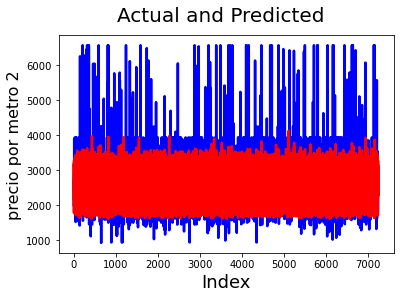

In [533]:
# Actual and Predicted
c = [i for i in range(1,7250,1)] # generamos el indíce 
fig = plt.figure() 
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-") #Plotting Actual
plt.plot(c,y_pred, color="red",  linewidth=2.5, linestyle="-") #Plotting predicted
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('precio por metro 2', fontsize=16)                       # Y-label

Text(0, 0.5, 'ytest-ypred')

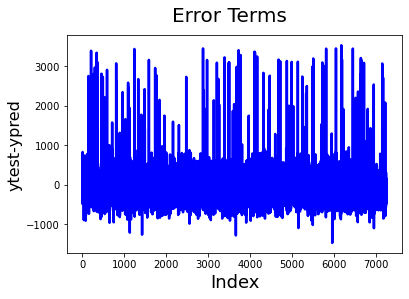

In [534]:
# Error terms
c = [i for i in range(1,7250,1)]
fig = plt.figure()
plt.plot(c,y_test-y_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)                # Y-label

Text(0, 0.5, 'y_pred')

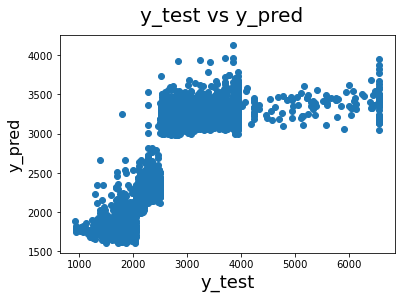

In [535]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

Text(0, 0.5, 'Index')

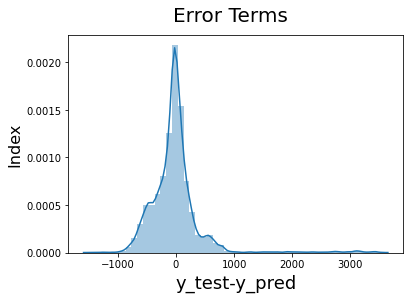

In [536]:
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label

### Aplicamos el modelo de Sklearn con Ridge y Lasso

In [537]:
X_proc_test.drop(['x1_terraza','apto_profesional','expenses_ok','amb_clean_final'], axis=1,inplace=True)
X_proc_test

,m2_total_clean_3,amenities,x0_si,x1_balcon,x1_patio,x2_bajo,x2_medio,x2_medio_bajo
0,34.000000,6.0,0.0,1.0,0.0,0.0,0.0,0.0
1,65.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,46.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,45.000000,2.0,0.0,1.0,0.0,0.0,0.0,0.0
4,40.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
7244,67.571429,5.0,1.0,1.0,0.0,0.0,1.0,0.0
7245,70.000000,2.0,1.0,1.0,0.0,0.0,1.0,0.0
7246,67.571429,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7247,20.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [538]:
X_proc_train.drop(['x1_terraza','apto_profesional','expenses_ok','amb_clean_final'], axis=1,inplace=True)
X_proc_train

,m2_total_clean_3,amenities,x0_si,x1_balcon,x1_patio,x2_bajo,x2_medio,x2_medio_bajo
0,64.000000,4.0,0.0,1.0,0.0,0.0,0.0,0.0
1,90.000000,6.0,0.0,1.0,0.0,0.0,0.0,0.0
2,65.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,67.571429,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,92.000000,5.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
16909,40.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0
16910,32.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16911,82.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0
16912,42.000000,5.0,0.0,1.0,0.0,0.0,0.0,0.0


In [1]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

lm = linear_model.LinearRegression(normalize=True)

model_1_2 = lm.fit(X_proc_train, y_train)

print('Score model_1:', model_1_2.score(X_proc_test, y_test))

NameError: name 'linear_model' is not defined

In [540]:
y_pred = lm.predict(X_proc_test)
regression_results(y_test, y_pred)

explained_variance:  0.6286
mean_squared_log_error:  0.0168
r2:  0.6286
MAE:  253.3462
MSE:  189657.1074
RMSE:  435.4964


In [541]:
cdf = pd.DataFrame(lm.coef_, X_proc_train.columns, columns=['Coefficients'])
print(cdf)

                  Coefficients
m2_total_clean_3      1.281755
amenities            29.977154
x0_si               122.780900
x1_balcon           -66.561445
x1_patio           -139.480589
x2_bajo           -1398.046100
x2_medio           -869.210046
x2_medio_bajo     -1032.415070


In [ ]:
y_pred = lm.predict(X_proc_test)
y_pred.shape

In [551]:
# Ahora entrenamos el modelo con todas las variables con Ridge:

lm_ridge = linear_model.RidgeCV(alphas=np.linspace(0.1,100,100),\
                                        normalize=True, cv=5) 
# Definimos el rango de de búsqueda del hiperparametro explicitamente

model_1_3 = lm_ridge.fit(X_proc_train, y_train)

print('Score model_4:', model_1_3.score(X_proc_test, y_test))

# ¿Mejoraron los resultados?

Score model_4: 0.6170369297815443


In [552]:
y_pred = lm_ridge.predict(X_proc_test)
regression_results(y_test, y_pred)

explained_variance:  0.6172
mean_squared_log_error:  0.0173
r2:  0.617
MAE:  252.1619
MSE:  195546.0682
RMSE:  442.2059


In [553]:
cdf = pd.DataFrame(lm_ridge.coef_, X_proc_train.columns, columns=['Coefficients'])
print(cdf)

                  Coefficients
m2_total_clean_3      1.242037
amenities            35.316404
x0_si               141.396026
x1_balcon           -54.150606
x1_patio           -151.647565
x2_bajo           -1190.767766
x2_medio           -719.220228
x2_medio_bajo      -846.052564


In [549]:
# Ahora entrenamos el modelo con todas las variables con Lasso:

lm_lasso = linear_model.LassoCV(alphas=np.linspace(0.1,100,100),
#                                 [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
#                                         0.05, 0.1, 1, 5, 10, 15, 25],\
                                        normalize=True, cv=5)

model_1_4 = lm_lasso.fit(X_proc_train, y_train)

print('Score model_5:', model_1_4.score(X_proc_test, y_test))

Score model_5: 0.627408621054519


In [545]:
y_pred = lm_lasso.predict(X_proc_test)
regression_results(y_test, y_pred)

explained_variance:  0.6275
mean_squared_log_error:  0.0164
r2:  0.6274
MAE:  246.3125
MSE:  190250.1438
RMSE:  436.1767


In [550]:
cdf = pd.DataFrame(lm_lasso.coef_, X_proc_train.columns, columns=['Coefficients'])
print(cdf)

                  Coefficients
m2_total_clean_3      1.126192
amenities            24.895734
x0_si               100.068744
x1_balcon           -21.121609
x1_patio            -74.754190
x2_bajo           -1343.581389
x2_medio           -823.382381
x2_medio_bajo      -957.146000


## Modelo final 

El modelo final deberia ser el de LinearRegression tiene mas R2 y menos RMSE

In [546]:
lm = linear_model.LinearRegression(normalize=True)
model_final = lm.fit(X_proc_train, y_train)
y_pred = lm.predict(X_proc_test)
regression_results(y_test, y_pred)


explained_variance:  0.6286
mean_squared_log_error:  0.0168
r2:  0.6286
MAE:  253.3462
MSE:  189657.1074
RMSE:  435.4964


In [547]:
coeficientes = pd.DataFrame(lm.coef_, X_proc_train.columns, columns=['Coefficients'])
print(cdf)

                  Coefficients
m2_total_clean_3      1.281755
amenities            29.977154
x0_si               122.780900
x1_balcon           -66.561445
x1_patio           -139.480589
x2_bajo           -1398.046100
x2_medio           -869.210046
x2_medio_bajo     -1032.415070
